In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
%matplotlib inline


In [60]:
data = pd.read_csv("./data/fraud_detection_data.csv")

print("\nCouple of rows:")
print(data.head())

print("\nHow many merchants and customers:")
print(data['nameDest'].str[0].value_counts())

print("\nShape of the data:\n")
print(data.shape)

print("\nDescription of the data:\n")
print(data.describe())

print("\nInfo about the data:\n")
print(data.info())

print("\n null values in the data:\n")
data.isnull().sum()

#making copy od data (work and modify on data_clean)
data_clean = data.copy()




Couple of rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

How many merchants and customers:
nameDest
C    4211125
M    2151495
Name: count, dtype

In [61]:
data_clean.head()

print("\nShape of the data_clean:\n")
print(data_clean.shape)

print("\nDescription of the data_clean:\n")
print(data_clean.describe())

print("\nInfo about the data_clean:\n")
print(data_clean.info())


Shape of the data_clean:

(6362620, 11)

Description of the data_clean:

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000

In [3]:
data["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [4]:
#checking for any negative values .lt(0) cz it is impossible
balance_cols = [
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest"
]

data[balance_cols].lt(0).any()

oldbalanceOrg     False
newbalanceOrig    False
oldbalanceDest    False
newbalanceDest    False
dtype: bool

In [23]:
print(f" fow many fraud incidents: \n {data["isFraud"].value_counts()}")
data.groupby("type")["isFraud"].mean().sort_values(ascending=False)


 fow many fraud incidents: 
 isFraud
0    6354407
1       8207
Name: count, dtype: int64


type
TRANSFER    0.007688
CASH_OUT    0.001837
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [7]:
zero_in_balance_cols=data[(data[balance_cols] == 0).all(axis=1)]
print(f"how mnay 0 in balance col {len(zero_in_balance_cols)}")
zero_in_balance_cols

how mnay 0 in balance col 774275


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
29,1,PAYMENT,9920.52,C764826684,0.0,0.0,M1940055334,0.0,0.0,0,0
30,1,PAYMENT,3448.92,C2103763750,0.0,0.0,M335107734,0.0,0.0,0,0
31,1,PAYMENT,4206.84,C215078753,0.0,0.0,M1757317128,0.0,0.0,0,0
32,1,PAYMENT,5885.56,C840514538,0.0,0.0,M1804441305,0.0,0.0,0,0
33,1,PAYMENT,5307.88,C1768242710,0.0,0.0,M1971783162,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6355957,709,PAYMENT,20380.42,C619971661,0.0,0.0,M1289697387,0.0,0.0,0,0
6355981,709,PAYMENT,5387.46,C460753297,0.0,0.0,M573565290,0.0,0.0,0,0
6355984,709,PAYMENT,3837.05,C1751522910,0.0,0.0,M903863937,0.0,0.0,0,0
6356244,709,PAYMENT,14499.40,C1009494758,0.0,0.0,M840318507,0.0,0.0,0,0


In [8]:
#checking and dropping the all zero rows or accounts 
zero_rows = data[
    (data["amount"] == 0) &
    (data["oldbalanceOrg"] == 0) &
    (data["newbalanceOrig"] == 0) &
    (data["oldbalanceDest"] == 0) &
    (data["newbalanceDest"] == 0)
]

print("Number of zero rows:", len(zero_rows))
zero_rows.head(6)

#dropping them 
data = data.drop(zero_rows.index)


Number of zero rows: 6


In [9]:
# checking for any mimatching between orinal balance and new according to amount sent from the org
# as well as old balance destination and new according to money transferred to 
# did it with tol so it isnt exactly the same != but to be almost the same (float amount)
tol = 1e-6

orig_mismatch = data[
    ~np.isclose(data["newbalanceOrig"], data["oldbalanceOrg"] - data["amount"], atol=tol)
]

dest_mismatch = data[
    ~np.isclose(data["newbalanceDest"], data["oldbalanceDest"] + data["amount"], atol=tol)
]
print(f" \n orig_mismatch data : \n {orig_mismatch}") 
print(f" \n dest_mismatch data : \n {dest_mismatch}")

 
 orig_mismatch data : 
          step      type       amount     nameOrig  oldbalanceOrg  \
8           1   PAYMENT      4024.36  C1265012928        2671.00   
10          1     DEBIT      9644.94  C1900366749        4465.00   
13          1   PAYMENT     11633.76  C1716932897       10127.00   
15          1  CASH_OUT    229133.94   C905080434       15325.00   
16          1   PAYMENT      1563.82   C761750706         450.00   
...       ...       ...          ...          ...            ...   
6362321   718  CASH_OUT    186273.84   C102120699      168046.00   
6362322   718  TRANSFER     82096.45   C614459560       13492.00   
6362460   730  TRANSFER  10000000.00  C2140038573    17316255.05   
6362462   730  TRANSFER   7316255.05  C1869569059    17316255.05   
6362584   741  TRANSFER   5674547.89   C992223106     5674547.89   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
8                  0.00  M1176932104            0.00            0.00        

In [ ]:
# making a feature out of these mismatching rows or accounts above 
data["orig_mismatch_flag"] = (~np.isclose(data["newbalanceOrig"], data["oldbalanceOrg"] - data["amount"], atol=tol)).astype(int)
data["dest_mismatch_flag"] = (~np.isclose(data["newbalanceDest"], data["oldbalanceDest"] + data["amount"], atol=tol)).astype(int)


In [48]:
#checking for 0 values count beside the dropped columns 
numeric = data.select_dtypes(include="number").columns.drop("isFraud").drop("isFlaggedFraud").drop("step")
(data[numeric] == 0).sum().sort_values(ascending=False).reset_index()



,index,0
0,suspicious_dest_balance,6346021
1,newbalanceOrig,3609560
2,oldbalanceDest,2704382
3,newbalanceDest,2439427
4,oldbalanceOrg,2102443
5,amount,10


In [11]:
#checking the suspicious accounts and calculating the fraud mean only in ("TRANSFER","CASH_OUT")
suspect1 = data[
    (data["oldbalanceOrg"] == 0) &
    (data["amount"] > 0) &
    (data["type"].isin(["TRANSFER","CASH_OUT"]))
]

suspect2 = data[
    (data["newbalanceDest"] == 0) &
    (data["amount"] > 0) &
    (data["type"].isin(["TRANSFER","CASH_OUT"]))
]
suspect3 = data[
    (data["oldbalanceDest"] ==0) &
    (data["amount"] > 0)&
    (data["type"].isin(["TRANSFER","CASH_OUT"]))

]

print("Fraud rate suspect1:", suspect1["isFraud"].mean())
print("Fraud rate suspect2:", suspect2["isFraud"].mean())
print("Fraud rate suspect3:", suspect3["isFraud"].mean())



Fraud rate suspect1: 1.9104882749513588e-05
Fraud rate suspect2: 0.24618815163020552
Fraud rate suspect3: 0.013729277652486167


C:\Users\dell\AppData\Local\Temp\ipykernel_18876\1683141027.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = data.groupby("amount_bin")["isFraud"].mean()


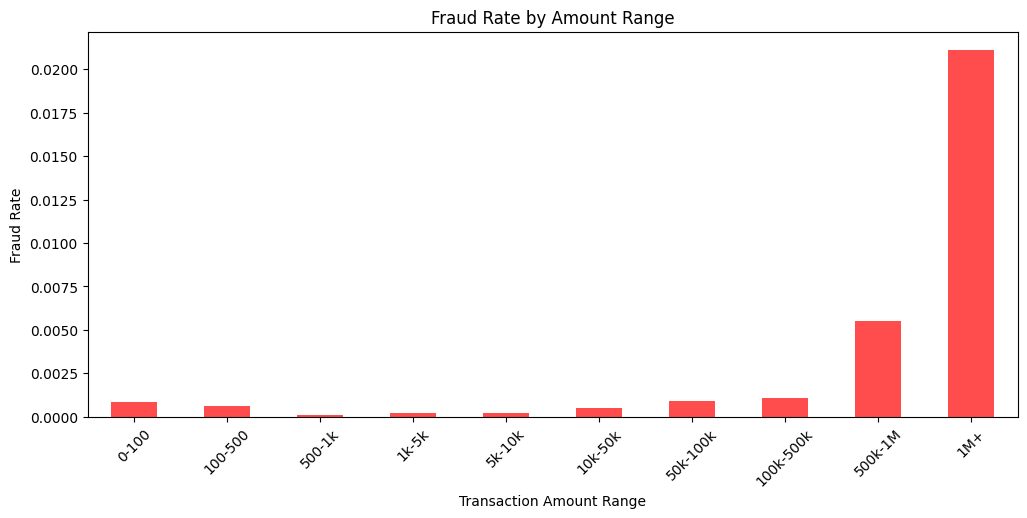

In [46]:
#need to visualize the fraud rate with amount so divided them to bins 
bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1e6, 1e7]
labels = ["0-100","100-500","500-1k","1k-5k","5k-10k","10k-50k","50k-100k","100k-500k","500k-1M","1M+"]

data["amount_bin"] = pd.cut(data["amount"], bins=bins, labels=labels, include_lowest=True)

fraud_rate_by_bin = data.groupby("amount_bin")["isFraud"].mean()

plt.figure(figsize=(12,5))
fraud_rate_by_bin.plot(kind="bar", color="red", alpha=0.7)
plt.title("Fraud Rate by Amount Range")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()


In [54]:
numeric_cols=data.select_dtypes(include="number").columns.drop("isFraud")
corr_with_target = data[numeric_cols].corrwith(data["isFraud"]).abs()
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target

suspicious_dest_balance    0.348902
amount                     0.076724
isFlaggedFraud             0.044125
step                       0.031539
oldbalanceOrg              0.010166
newbalanceOrig             0.008143
oldbalanceDest             0.005879
newbalanceDest             0.000544
dtype: float64

In [64]:
#added a new feature after i found the 24% chance of fraud in suspect2
data_clean["suspicious_dest_balance"] = (
    (data_clean["newbalanceDest"] == 0) &
    (data_clean["amount"] > 0) &
    (data_clean["type"].isin(["TRANSFER","CASH_OUT"]))
).astype(int)


In [75]:
data_clean["name_org_type"]=data_clean["nameOrig"].str[0]
data_clean["name_dest_type"]=data_clean["nameDest"].str[0]

In [77]:
print(f"name original type : {data_clean["name_org_type"].value_counts()}")
print(f"name destination type : {data_clean["name_dest_type"].value_counts()}")


name original type : name_org_type
C    6362620
Name: count, dtype: int64
name destination type : name_dest_type
C    4211125
M    2151495
Name: count, dtype: int64


In [82]:
# First time seen destination
data_clean["is_new_dest"] = (~data_clean["nameDest"].duplicated()).astype(int)

# Destination used only once ever
data_clean["is_unique_dest"] = (
    data_clean["nameDest"].map(data_clean["nameDest"].value_counts()) == 1
).astype(int)


In [83]:
for col in data_clean.columns:
    print(col)

step
type
amount
nameOrig
oldbalanceOrg
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
suspicious_dest_balance
name_org_type
name_dest_type
is_new_dest
is_unique_dest


In [86]:
print(data_clean["is_new_dest"])
print(data_clean["is_unique_dest"])



0          1
1          1
2          1
3          1
4          1
          ..
6362615    0
6362616    1
6362617    0
6362618    1
6362619    0
Name: is_new_dest, Length: 6362620, dtype: int64
0          1
1          1
2          0
3          0
4          1
          ..
6362615    0
6362616    1
6362617    0
6362618    1
6362619    0
Name: is_unique_dest, Length: 6362620, dtype: int64


In [88]:
correlation = data_clean[["is_new_dest", "is_unique_dest"]].corrwith(data_clean["isFraud"])
print(correlation)


is_new_dest       0.014686
is_unique_dest   -0.002265
dtype: float64
